# Analysis of the pretrained facenet

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [5]:
#import itables
#from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
#import papermill as pm

In [10]:
import math

In [11]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [12]:
import sys
import os

In [13]:
import functools

In [14]:
import tensorflow as tf

In [15]:
import torch
import torchvision

In [16]:
from einops import *

In [17]:
import cv2

In [18]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [19]:
import networkx as nx

In [20]:
from pathlib import Path

## Load in the pretrained facenet

In [21]:
import model
from model import face_model

In [22]:
import importlib
model = importlib.reload(model)
face_model = model.face_model

In [23]:
class Params():
    def __init__(self):
        self.image_size = 250
        self.embedding_size=128

In [24]:
fm = face_model(Params())

In [25]:
checkpoint = tf.train.Checkpoint(fm)

In [26]:
checkpoint.restore('../weights/weights/ckpt/ckpt-11')

In [27]:
#!mkdir saved_model
#fm.save('saved_model/my_model')

In [28]:
#import onnx
#from onnx2torch import convert
#onnx_model_path = 'model.onnx'
#onnx_model = onnx.load(onnx_model_path)
#torch_model_1 = convert(onnx_model)

## Load in our Casuarina images

In [29]:
ROOT_DIR = Path(r'E:\FRDC-ML\src\frdc\conf.py').parents[2]
LOCAL_DATASET_ROOT_DIR = ROOT_DIR / 'rsc'
LOCAL_BACKEND_DATA_ROOT_DIR = ROOT_DIR / 'backend-rsc'
SECRETS_DIR = ROOT_DIR / '.secrets'
GCS_PROJECT_ID = 'frmodel'
GCS_BUCKET_NAME = 'frdc-scan'
GCS_BACKEND_BUCKET_NAME = 'files-from-backend'

In [30]:
LOCAL_DATASET_ROOT_DIR

WindowsPath('E:/FRDC-ML/rsc')

In [31]:
sys.path.append('E:\FRDC-ML\src')

In [32]:
import frdc
import frdc.load
import frdc.conf

In [33]:
bands = dict(BLUE=frdc.conf.Band.BLUE,
             GREEN=frdc.conf.Band.GREEN,
             RED=frdc.conf.Band.RED,
             RED_EDGE=frdc.conf.Band.RED_EDGE,
             NIR=frdc.conf.Band.NIR)
band_names = ['blue', 'green', 'red', 'red_edge', 'nir']

In [34]:
ds_93deg =\
frdc.load.FRDCDataset('casuarina', '20220418', '93deg',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

E:\miniconda3\envs\work_env\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [35]:
ar_93deg = ds_93deg.get_ar_bands()

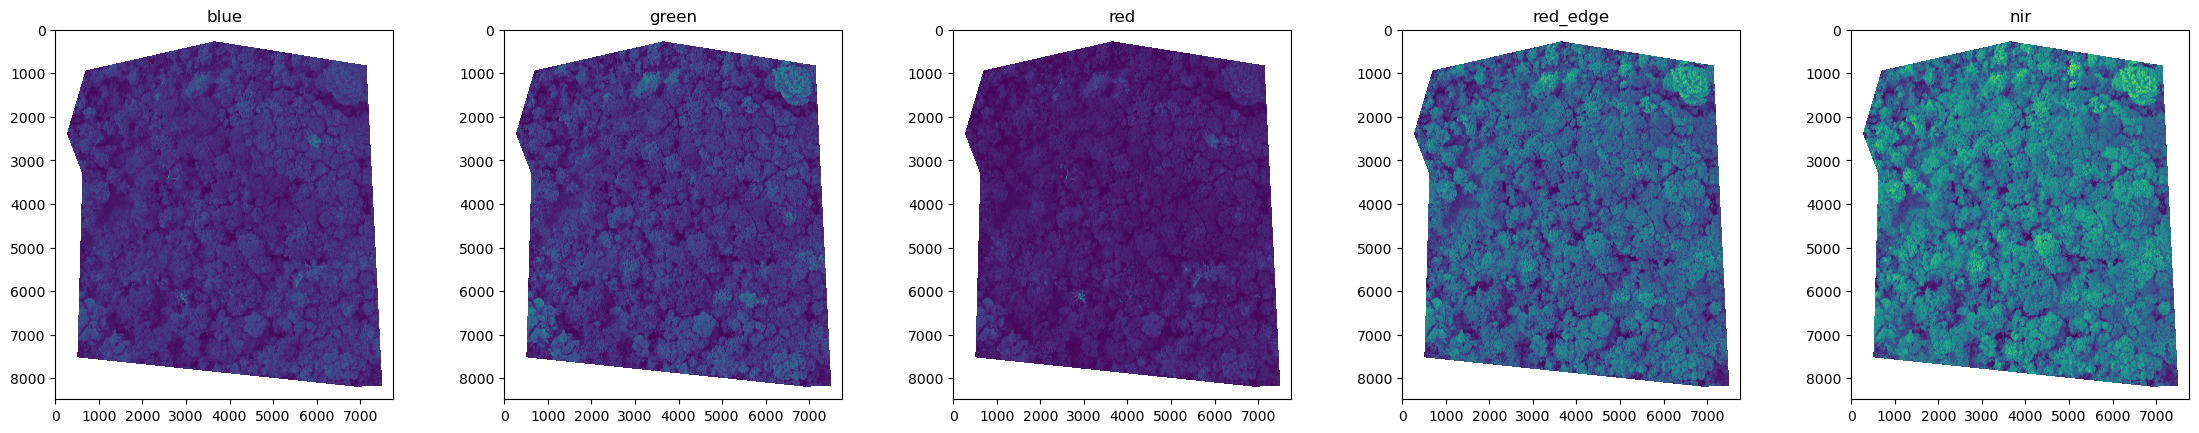

In [36]:
fig, ax = plt.subplots(1, ncols:=ar_93deg.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_93deg[:,:,idx])
    box.set_title(band_names[idx])

In [36]:
ds_183deg =\
frdc.load.FRDCDataset('casuarina', '20220418', '183deg',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [37]:
ar_183deg = ds_183deg.get_ar_bands()

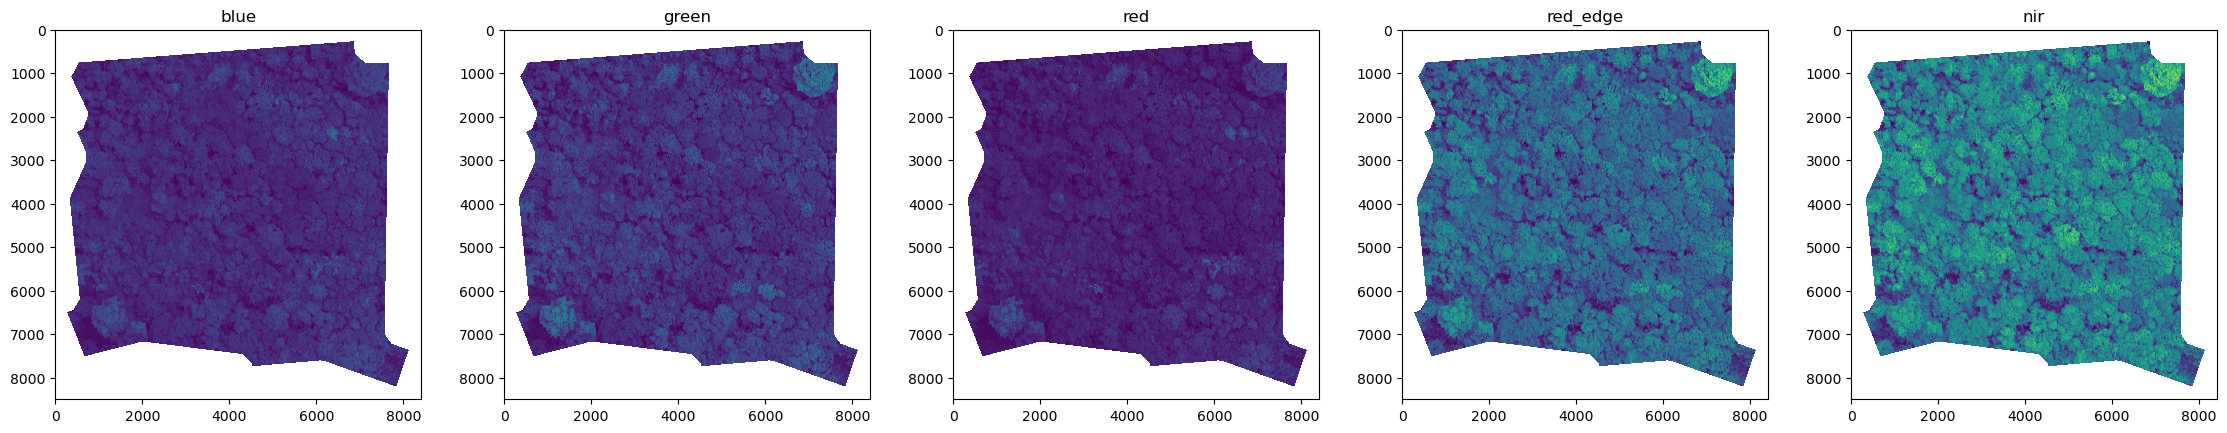

In [39]:
fig, ax = plt.subplots(1, ncols:=ar_183deg.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_183deg[:,:,idx])
    box.set_title(band_names[idx])

## Load in our Chestnut images

In [38]:
ds_december =\
frdc.load.FRDCDataset('chestnut_nature_park', '20201218', None,
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [39]:
ar_december = ds_december.get_ar_bands()

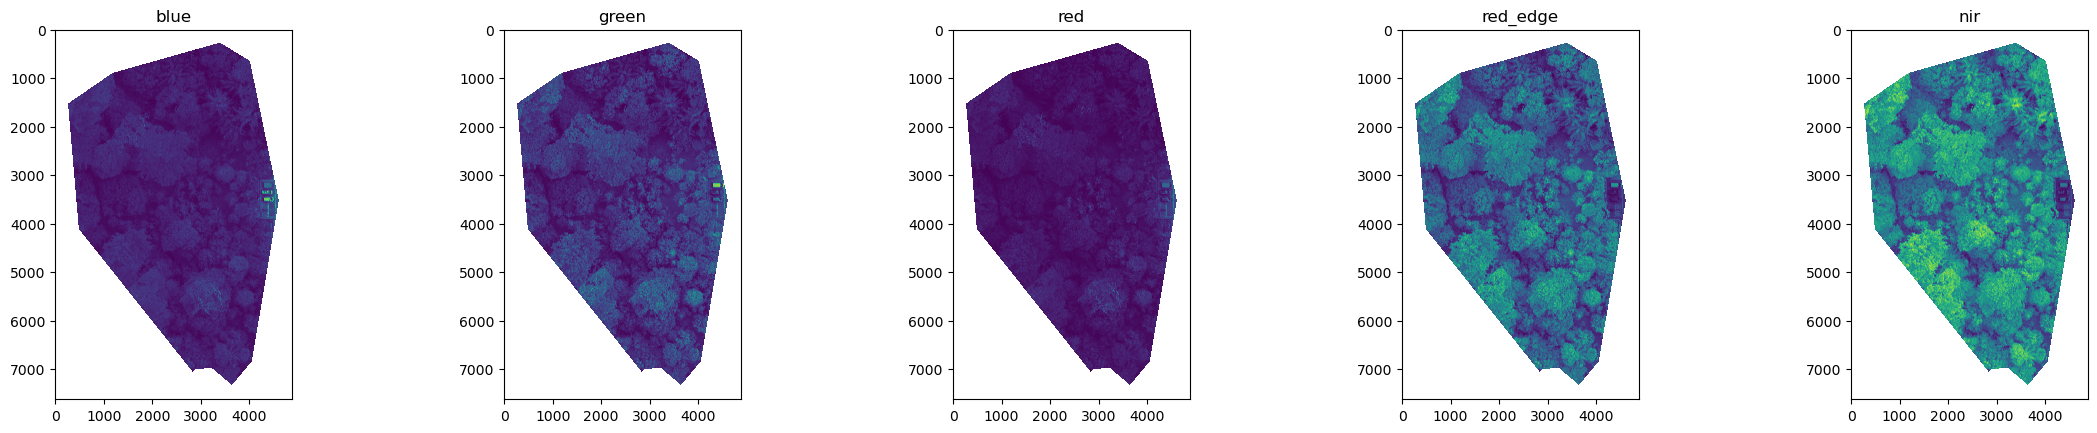

In [42]:
fig, ax = plt.subplots(1, ncols:=ar_december.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_december[:,:,idx])
    box.set_title(band_names[idx])

In [40]:
ds_may =\
frdc.load.FRDCDataset('chestnut_nature_park', '20210510', '90deg43m85pct255deg/map',
                      dl=frdc.load.FRDCDownloader(local_dataset_root_dir=LOCAL_DATASET_ROOT_DIR))

In [41]:
ar_may = ds_may.get_ar_bands()

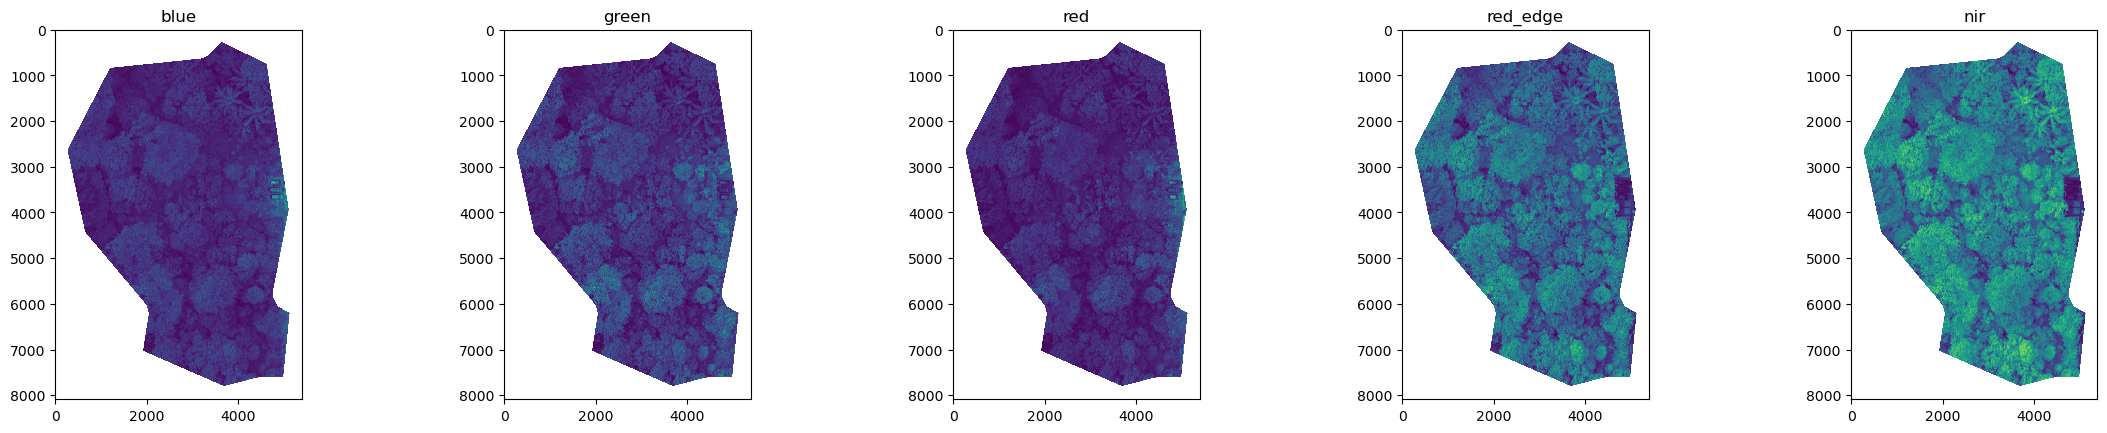

In [45]:
fig, ax = plt.subplots(1, ncols:=ar_may.shape[-1], figsize=(5.6*ncols, 4.8))
for box, idx in zip(ax, range(ncols)):
    box.imshow(ar_may[:,:,idx])
    box.set_title(band_names[idx])

## Load in our Chestnut dataframe

In [42]:
df_chestnut = pd.read_pickle('df_augment.pickle')

In [43]:
df_chestnut = df_chestnut.reset_index()

In [44]:
df_chestnut.columns

Index(['index', 'npz_path', 'path_str_split', 'phase', 'filename', 'species',
       'tree_id', 'glcm', 'sel_features', 'pre_pca_augment',
       'pre_pca_augment_embeddings'],
      dtype='object')

In [45]:
bands_chestnut = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']
bands_sel = ['re', 'b', 'nir', 'r', 'g']
props_chestnut = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [46]:
df_chestnut.shape

(1320, 11)

In [47]:
df_chestnut['sel_features'].iloc[0].shape

(238, 266, 10)

In [48]:
df_chestnut['glcm'].iloc[0].shape

(238, 266, 8, 7)

In [49]:
df_chestnut_unaug = df_chestnut.drop_duplicates('index')

## How do the histograms for May, December, 93deg and 183deg differ?

In [50]:
df_tifs = pd.DataFrame(['ar_93deg', 'ar_183deg', 'ar_may', 'ar_december'], columns=['arr_name'])

In [51]:
df_tifs['arr'] = None
df_tifs['arr'] = df_tifs['arr'].astype('object')
df_tifs = df_tifs.copy()

In [52]:
df_tifs.loc[0]['arr'] = ar_93deg
df_tifs.loc[1]['arr'] = ar_183deg
df_tifs.loc[2]['arr'] = ar_may
df_tifs.loc[3]['arr'] = ar_december

In [53]:
df_tifs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   arr_name  4 non-null      object
 1   arr       4 non-null      object
dtypes: object(2)
memory usage: 196.0+ bytes


In [54]:
for band in band_names:
    df_tifs[band] = df_tifs['arr'].progress_apply(lambda x: x[:,:,band_names.index(band)].flatten())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
for band in band_names:
    df_tifs[band] = df_tifs[band].apply(lambda x: [x[np.random.randint(len(x))] for i in tqdm(range(20_000))])

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [56]:
df_px_vals = df_tifs[['arr_name'] + band_names].explode(band_names)

In [57]:
df_px_vals = pd.melt(df_px_vals, id_vars=['arr_name'], ignore_index=False)

In [58]:
df_px_vals = df_px_vals.dropna()

In [59]:
df_px_vals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265391 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   arr_name  265391 non-null  object
 1   variable  265391 non-null  object
 2   value     265391 non-null  object
dtypes: object(3)
memory usage: 8.1+ MB


In [60]:
gc.collect()

896

E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\miniconda3\envs\work_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

<Axes: xlabel='value', ylabel='Count'>

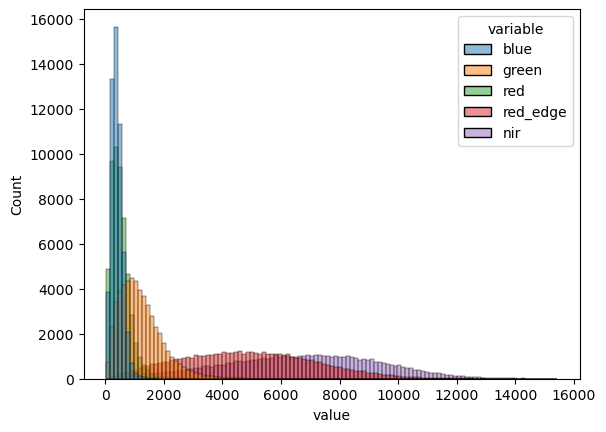

In [96]:
sns.histplot(df_px_vals.reset_index(), x='value', hue='variable')

In [61]:
arr_names = df_px_vals['arr_name'].unique()

In [62]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

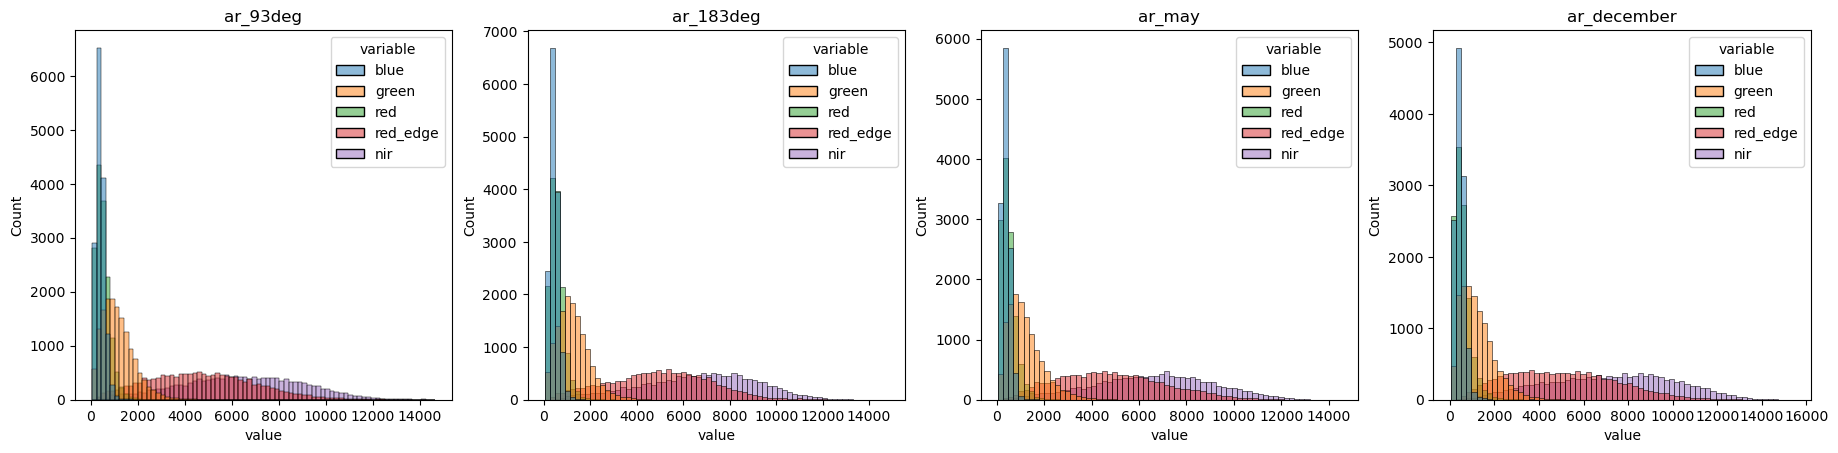

In [105]:
fig, ax = plt.subplots(1, ncols:=len(arr_names), figsize=(5.6*ncols, 4.8))
for box, arr_name in zip(ax, arr_names):
    sns.histplot(df_px_vals[df_px_vals['arr_name'] == arr_name].reset_index(),
                 x='value', hue='variable',
                 ax=box)
    box.set_title(arr_name)

In [63]:
band_names

['blue', 'green', 'red', 'red_edge', 'nir']

In [64]:
df_px_vals.columns = ['arr_name', 'band', 'value']

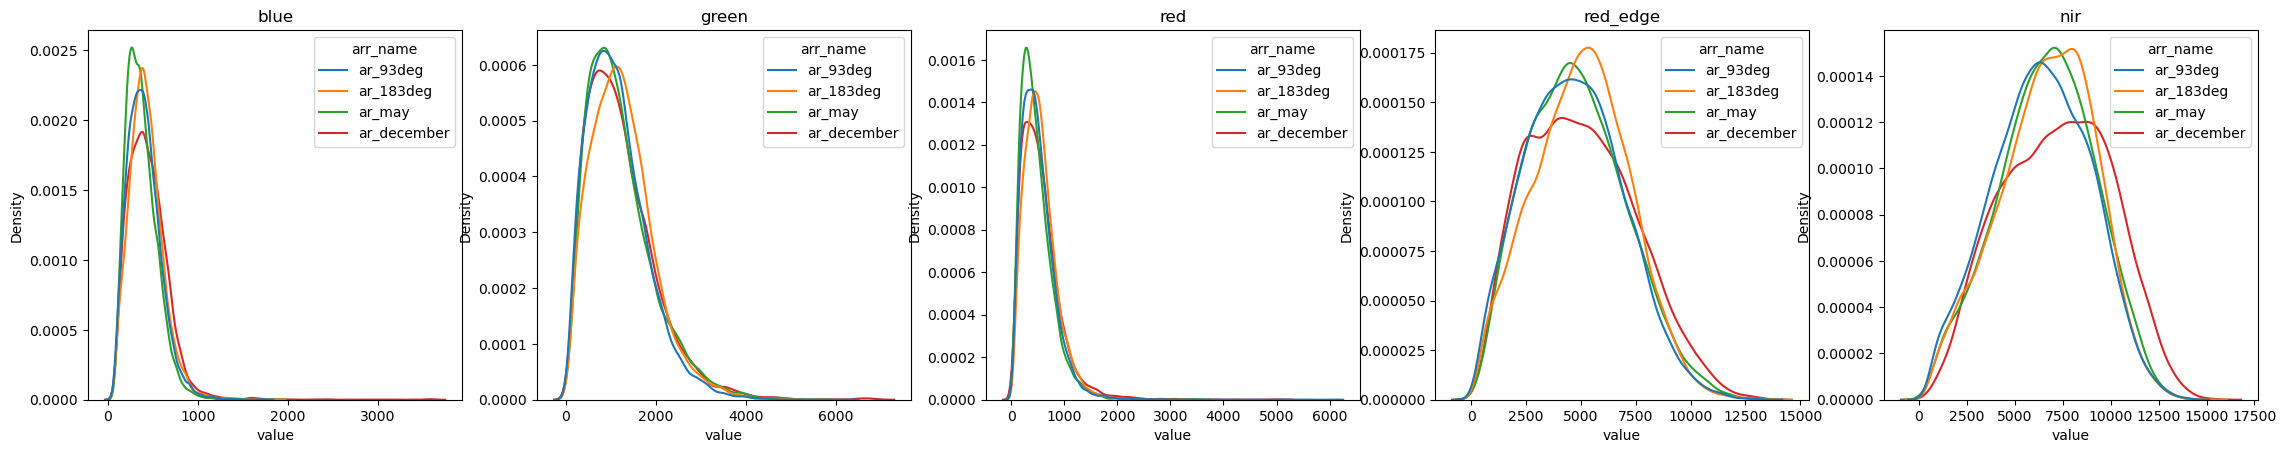

In [75]:
fig, ax = plt.subplots(1, ncols:=len(band_names), figsize=(5.6*ncols, 4.8))
for box, band_name in zip(ax, band_names):
    sns.kdeplot(df_px_vals[df_px_vals['band'] == band_name].reset_index(),
                 x='value', hue='arr_name',
                 common_norm=False,
                 ax=box)
    box.set_title(band_name)

In [65]:
band_names

['blue', 'green', 'red', 'red_edge', 'nir']

## Do May and December crop histograms match those of the images?

In [98]:
df_px_vals_from_crops = pd.DataFrame()
df_px_vals_from_crops['blue'] = df_chestnut_unaug['glcm'].progress_apply(lambda x: x[:,:,4,0].flatten()).progress_apply(lambda x: [x[np.random.randint(len(x))] for i in range(20_000//66)])
df_px_vals_from_crops['green'] = df_chestnut_unaug['glcm'].progress_apply(lambda x: x[:,:,7,0].flatten()).progress_apply(lambda x: [x[np.random.randint(len(x))] for i in range(20_000//66)])
df_px_vals_from_crops['red'] = df_chestnut_unaug['glcm'].progress_apply(lambda x: x[:,:,6,0].flatten()).progress_apply(lambda x: [x[np.random.randint(len(x))] for i in range(20_000//66)])
df_px_vals_from_crops['red_edge'] = df_chestnut_unaug['glcm'].progress_apply(lambda x: x[:,:,3,0].flatten()).progress_apply(lambda x: [x[np.random.randint(len(x))] for i in range(20_000//66)])
df_px_vals_from_crops['nir'] = df_chestnut_unaug['glcm'].progress_apply(lambda x: x[:,:,5,0].flatten()).progress_apply(lambda x: [x[np.random.randint(len(x))] for i in range(20_000//66)])

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [99]:
df_px_vals_from_crops['arr_name'] = df_chestnut['phase'].apply(lambda x: 'crops_may' if x == '10May2021' else 'crops_december')

In [100]:
df_px_vals_from_crops = df_px_vals_from_crops.explode(band_names)

In [101]:
df_px_vals_from_crops

blue     green       red  red_edge       nir        arr_name
0     0.039987  0.164946  0.061804  0.546788  0.521198       crops_may
0     0.040376   0.03657   0.03719  0.220725  0.519886       crops_may
0     0.037461  0.176671  0.038301  0.211417  0.496546       crops_may
0     0.039236  0.155478  0.084465  0.481293  0.503914       crops_may
0     0.019488  0.167018   0.05445  0.426846  0.537336       crops_may
...        ...       ...       ...       ...       ...             ...
1300  0.049504  0.184406  0.070553  0.320598  0.747208  crops_december
1300   0.03692  0.114602  0.078986  0.451131  0.717791  crops_december
1300  0.029852   0.08696   0.02442  0.614132  0.782907  crops_december
1300  0.046307  0.212971  0.049303  0.304236  0.408221  crops_december
1300   0.02148  0.162756  0.054248  0.271481  0.513141  crops_december

[19998 rows x 6 columns]

In [102]:
df_px_vals_from_crops = pd.melt(df_px_vals_from_crops, id_vars=['arr_name'], ignore_index=False)

In [103]:
df_px_vals_from_crops = df_px_vals_from_crops.dropna()

In [104]:
df_px_vals_from_crops.columns = ['arr_name', 'band', 'value']

In [105]:
df_px_vals_from_crops['value'] *= 16384

In [106]:
gc.collect()

19812

In [107]:
df_px_vals_with_crops = pd.concat((df_px_vals, df_px_vals_from_crops))

In [108]:
df_px_vals.shape

(265391, 3)

In [109]:
df_px_vals_from_crops.shape

(99990, 3)

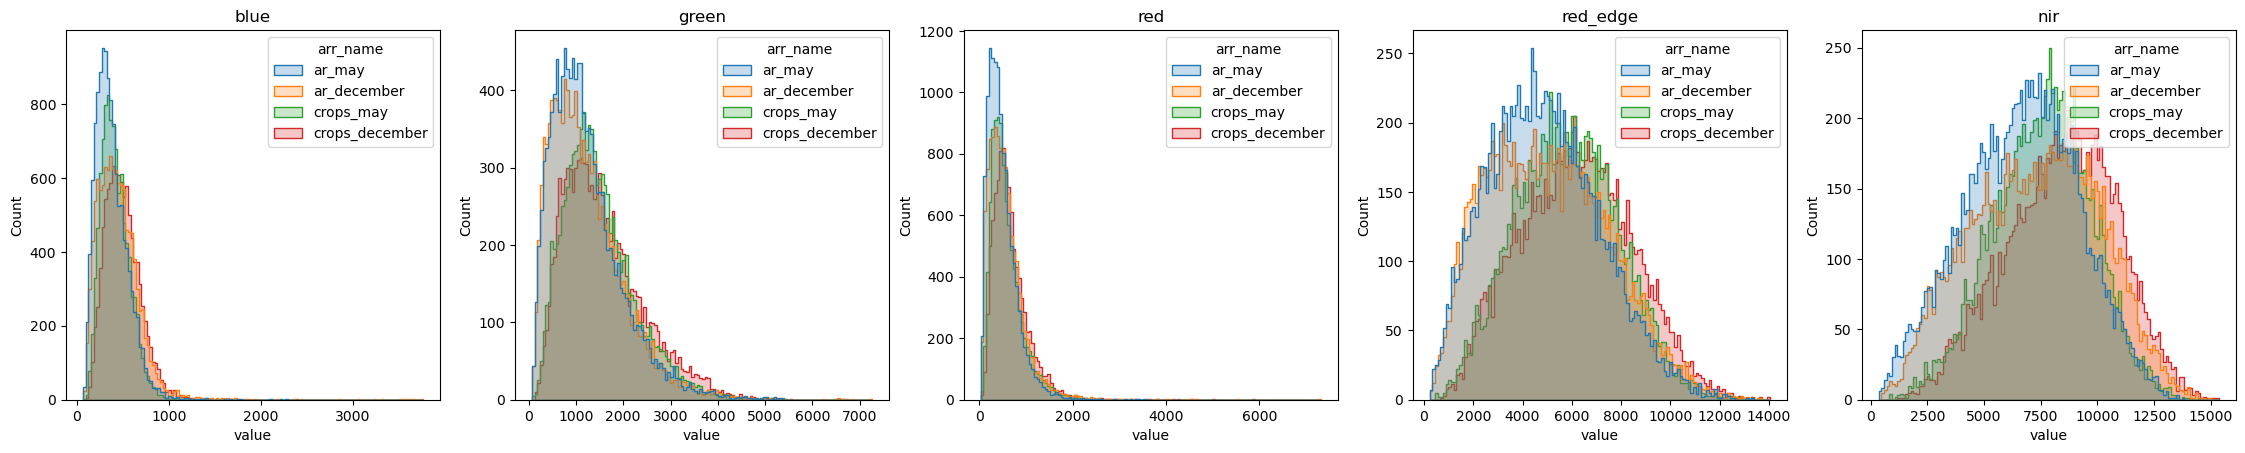

In [110]:
fig, ax = plt.subplots(1, ncols:=len(band_names), figsize=(5.6*ncols, 4.8))
for box, band_name in zip(ax, band_names):
    sns.histplot(df_px_vals_with_crops[(df_px_vals_with_crops['band'] == band_name) & ~(df_px_vals_with_crops['arr_name'].isin(['ar_93deg', 'ar_183deg']))]
                     .reset_index(),
                 x='value', hue='arr_name',
                 common_norm=False,
                 ax=box,
                 bins=128,
                 element='step')
    box.set_title(band_name)

## Get the widebands too for Casuarina

In [119]:
with rio.open(r'E:\FRDC-ML\rsc\casuarina\20220418\93deg\result.tif') as f:
    ar_93deg_widebands = rearrange(f.read(range(1, 3+1)), 'c h w -> h w c')

In [120]:
with rio.open(r'E:\FRDC-ML\rsc\casuarina\20220418\183deg\result.tif') as f:
    ar_183deg_widebands = rearrange(f.read(range(1, 3+1)), 'c h w -> h w c')

## Get our Campnosperma and Palm Tree bounds on the Casuarina data

In [121]:
campnospema_bounds_93deg = pd.read_csv('93deg Campnosperma boxes.csv',
                                       names=['name', 'ymin', 'ymax', 'xmin', 'xmax'],
                                       index_col=False)

In [122]:
campnospema_bounds_93deg['src'] = '93deg'

In [123]:
campnospema_bounds_183deg = pd.read_csv('183deg Campnosperma boxes.csv',
                                       names=['name', 'ymin', 'ymax', 'xmin', 'xmax'],
                                       index_col=False)

In [124]:
campnospema_bounds_183deg['src'] = '183deg'

In [125]:
campnospema_bounds = pd.concat((campnospema_bounds_93deg, campnospema_bounds_183deg))
campnospema_bounds = campnospema_bounds.reset_index(drop=True)

In [126]:
campnospema_bounds

name  ymin  ymax  xmin  xmax     src
0  Campnosperma N  4017  4166  4305  4485   93deg
1  Campnosperma S  4583  4702  4242  4421   93deg
2       Palm Tree  4471  4648  3706  3891   93deg
3  Campnosperma N  3833  3984  4717  4901  183deg
4  Campnosperma S  4403  4520  4639  4795  183deg
5       Palm Tree  4289  4450  4162  4334  183deg

In [159]:
names = list(campnospema_bounds['name'].unique())
srcs = list(campnospema_bounds['src'].unique())

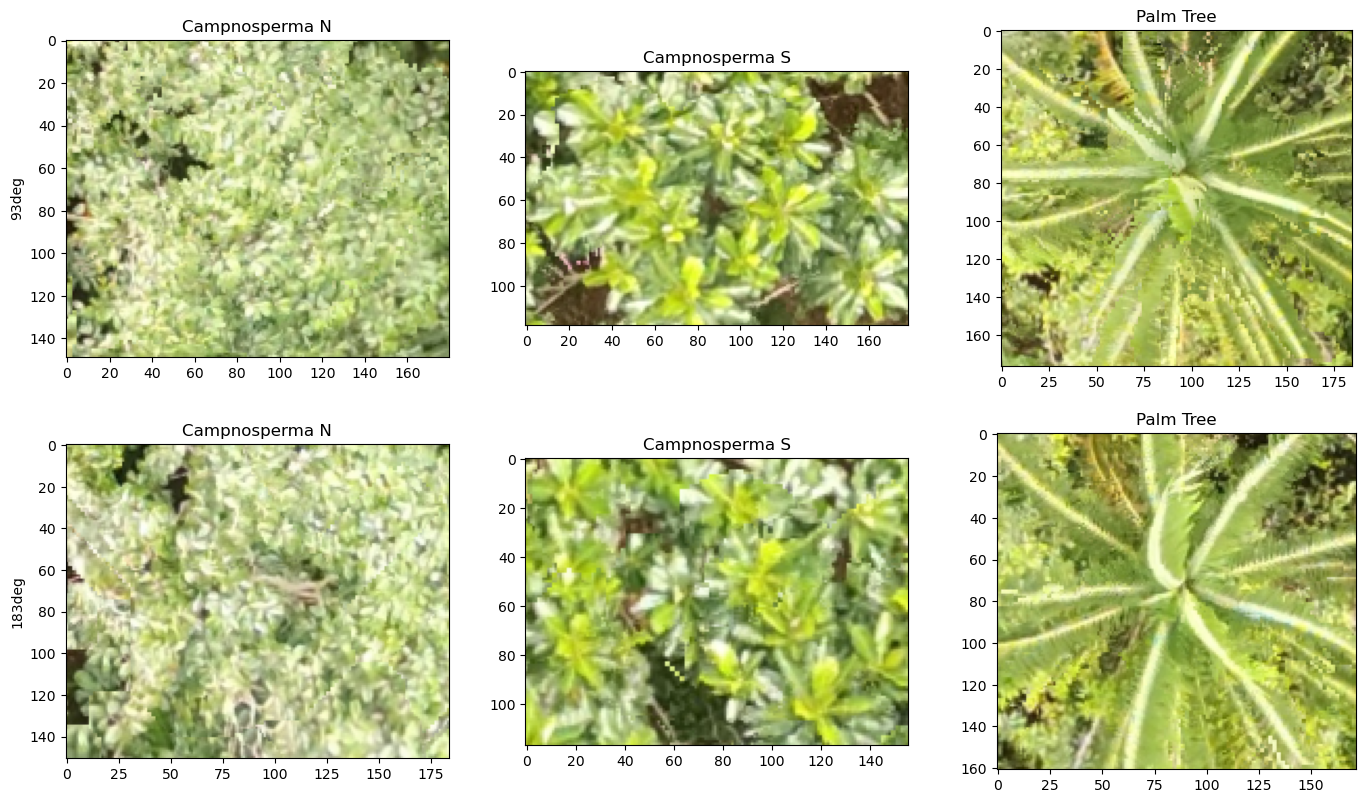

In [160]:
fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
for row, src in zip(ax, srcs):
    row[0].set_ylabel(src)
    for box, name in zip(row, names):
        bounds_row = campnospema_bounds[(campnospema_bounds['name'] == name) & (campnospema_bounds['src'] == src)]
        bounds_row = bounds_row.iloc[0]
        image = ar_93deg_widebands if src == '93deg' else ar_183deg_widebands
        crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']] / 255
        box.imshow(crop)
        box.set_title(name)

## Get our Macaranga Gigantea bounds on the Casuarina data

In [161]:
macaranga_bounds = [['src', 'name', 'ymin', 'ymax', 'xmin', 'xmax'],
                    ['183deg', 'macagi top', 1259, 1846, 4600, 5041],
                    ['183deg', 'macagi top left', 2207, 2623, 2626, 3200],
                    ['183deg', 'macagi middle', 2849, 3096, 4916, 5049],
                    ['183deg', 'macagi bottom', 3729, 3976, 3664, 3897],
                    ['93deg', 'macagi top', 1375, 2037, 4117, 4554],
                    ['93deg', 'macagi top left', 2393, 2793, 2193, 2709],
                    ['93deg', 'macagi middle', 3015, 3279, 4476, 4636],
                    ['93deg', 'macagi bottom', 3921, 4196, 3224, 3444]]
macaranga_bounds = pd.DataFrame(macaranga_bounds[1:], columns=macaranga_bounds[0])

In [116]:
macaranga_bounds

src             name  ymin  ymax  xmin  xmax
0  183deg       macagi top  1259  1846  4600  5041
1  183deg  macagi top left  2207  2623  2626  3200
2  183deg    macagi middle  2849  3096  4916  5049
3  183deg    macagi bottom  3729  3976  3664  3897
4   93deg       macagi top  1375  2037  4117  4554
5   93deg  macagi top left  2393  2793  2193  2709
6   93deg    macagi middle  3015  3279  4476  4636
7   93deg    macagi bottom  3921  4196  3224  3444

In [192]:
names = list(macaranga_bounds['name'].unique())
srcs = list(macaranga_bounds['src'].unique())

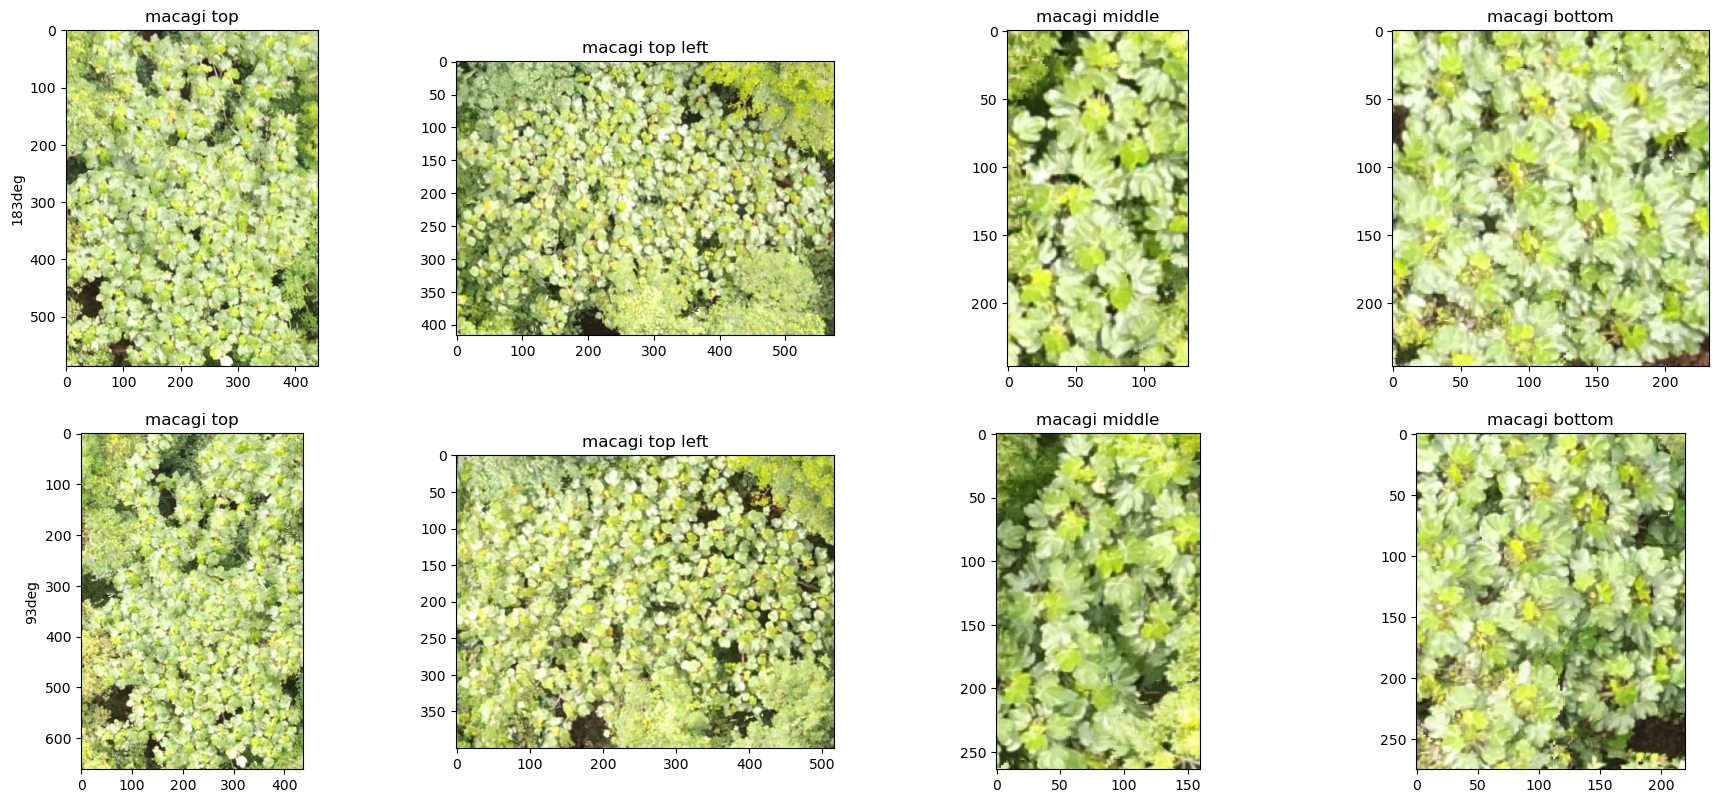

In [193]:
fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
for row, src in zip(ax, srcs):
    row[0].set_ylabel(src)
    for box, name in zip(row, names):
        bounds_row = macaranga_bounds[(macaranga_bounds['name'] == name) & (macaranga_bounds['src'] == src)]
        bounds_row = bounds_row.iloc[0]
        image = ar_93deg_widebands if src == '93deg' else ar_183deg_widebands
        crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']] / 255
        box.imshow(crop)
        box.set_title(name)

## Embed our Casuarina data

In [111]:
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    if y < cropy or x < cropx:
        return float('NaN')
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [162]:
names = list(macaranga_bounds['name'].unique())
srcs = list(macaranga_bounds['src'].unique())

In [163]:
macaranga_bounds['crop'] = None
for src in srcs:
    for name in names:
        bounds_row = macaranga_bounds[(macaranga_bounds['name'] == name) & (macaranga_bounds['src'] == src)]
        idx = bounds_row.index[0]
        bounds_row = bounds_row.iloc[0]
        image = ar_93deg if src == '93deg' else ar_183deg
        macaranga_bounds.at[idx, 'crop'] = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']]

In [164]:
macaranga_bounds['crop'] = macaranga_bounds['crop'].apply(lambda x: x[:,:,[band_names.index(i) for i in ['red_edge', 'blue', 'nir', 'red', 'green']]])

In [166]:
macaranga_bounds.to_pickle('casuarina.pickle')

## Discard our Chestnut images

In [ ]:
del ds_93deg, ar_93deg
del ds_183deg, ar_183deg
del ds_may, ar_may
del ds_december, ar_december

In [ ]:
gc.collect()

In [ ]:
del df_tifs
del df_px_vals

In [ ]:
gc.collect()